# Inflammation and Cardiovascular Disease

The aim of this research project is to assess the relationship between inflammatory biomarkers and the risk of cardiovascular-disease related mortality specifically within the population of interest, adults 65 years and older.

Data used is a sample of 5,000 relatively healthy elderly participants, sourced from The Cardiovascular Health Study.

Inflammatory biomarkers include blood C-reactive protein (CRP) and blood fibrinogen. Other features are related to demographics and health status.

In [185]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from scipy import stats
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
%config InlineBackend.figure_format = 'retina'
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score
from scipy.stats import chi2_contingency
from sklearn.utils import resample

In [156]:
! wget 'https://biostat.app.vumc.org/wiki/pub/Main/CourseBios312/inflamm.txt inflamm.txt'

--2023-10-12 16:09:31--  https://biostat.app.vumc.org/wiki/pub/Main/CourseBios312/inflamm.txt%20inflamm.txt
Resolving biostat.app.vumc.org (biostat.app.vumc.org)... 160.129.8.31
Connecting to biostat.app.vumc.org (biostat.app.vumc.org)|160.129.8.31|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-10-12 16:09:32 ERROR 404: Not Found.



In [186]:
# datafile = os.path.expanduser('~/data/inflamm.txt')
data = pd.read_csv('inflamm.txt', delimiter='\t')

In [187]:
data.columns

Index(['id', 'site', 'age', 'male', 'bkrace', 'smoker', 'estrogen', 'prevdis',
       'diab2', 'bmi', 'systBP', 'aai', 'cholest', 'crp', 'fib', 'ttodth',
       'death', 'cvddth'],
      dtype='object')

In [188]:
data.shape

(5000, 18)

In [189]:
# No real difference across sites
pd.crosstab(index=data['site'], columns=data['cvddth'])

cvddth,0,1
site,,
1,1171,135
2,1209,98
3,973,144
4,1150,120


In [190]:
# Drop unnecessary columns
data = data.drop(columns=['id','site'])

In [191]:
# Drop rows with NAs (NAs are in the predictors of most interest)
# print(data.isnull().sum())
data.dropna(inplace=True)

In [192]:
len(data)

4743

In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4743 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       4743 non-null   int64  
 1   male      4743 non-null   int64  
 2   bkrace    4743 non-null   int64  
 3   smoker    4743 non-null   float64
 4   estrogen  4743 non-null   float64
 5   prevdis   4743 non-null   int64  
 6   diab2     4743 non-null   float64
 7   bmi       4743 non-null   float64
 8   systBP    4743 non-null   float64
 9   aai       4743 non-null   float64
 10  cholest   4743 non-null   float64
 11  crp       4743 non-null   float64
 12  fib       4743 non-null   float64
 13  ttodth    4743 non-null   int64  
 14  death     4743 non-null   int64  
 15  cvddth    4743 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 629.9 KB


In [194]:
# Numerical Variables
numerical = data.drop(columns=['male', 'bkrace', 'smoker', 'estrogen', 'prevdis', 'diab2', 'death', 'cvddth', 'ttodth']) #'death', 'cvddth', 'ttodth'
tab = numerical.describe().T
print(tab)

          count        mean        std       min    25%       50%       75%  \
age      4743.0   72.751001   5.519433   65.0000   68.0   71.0000   76.0000   
bmi      4743.0   26.640164   4.681150   14.7000   23.5   26.1000   29.1000   
systBP   4743.0  136.259119  21.670448   79.0000  121.0  134.0000  149.0000   
aai      4743.0    1.064570   0.174097    0.2778    1.0    1.0853    1.1667   
cholest  4743.0  211.717057  39.061190   73.0000  186.0  210.0000  236.0000   
crp      4743.0    3.602994   6.175991    0.0000    1.0    2.0000    3.0000   
fib      4743.0  322.858950  67.038062  109.0000  281.0  311.0000  361.0000   

              max  
age       95.0000  
bmi       58.8000  
systBP   235.0000  
aai        2.3846  
cholest  430.0000  
crp      108.0000  
fib      872.0000  


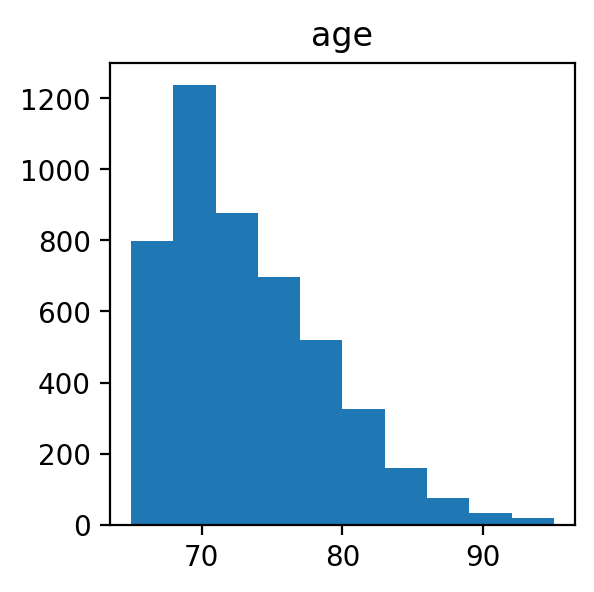

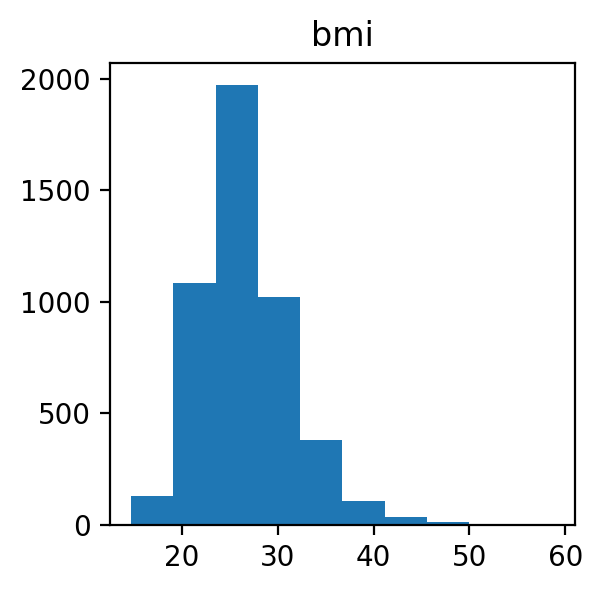

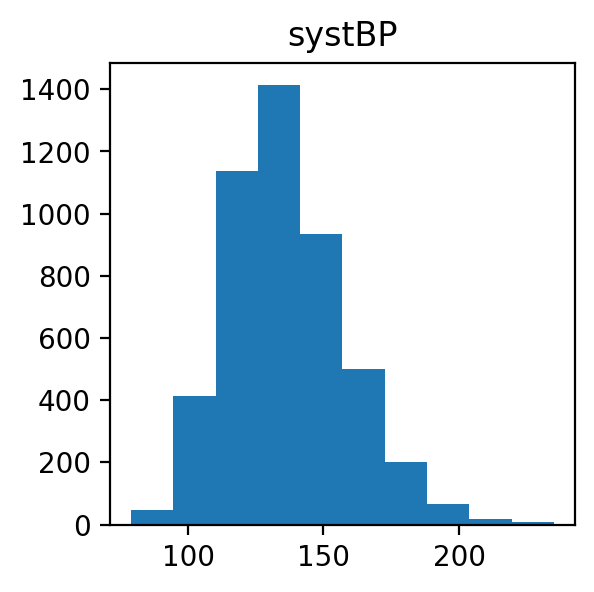

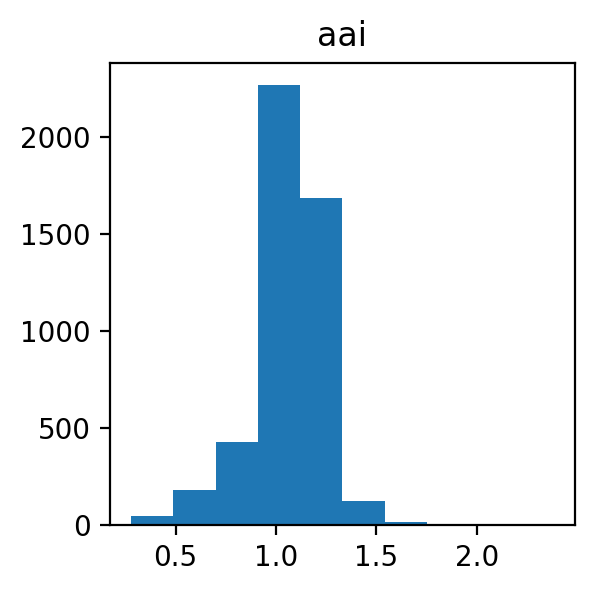

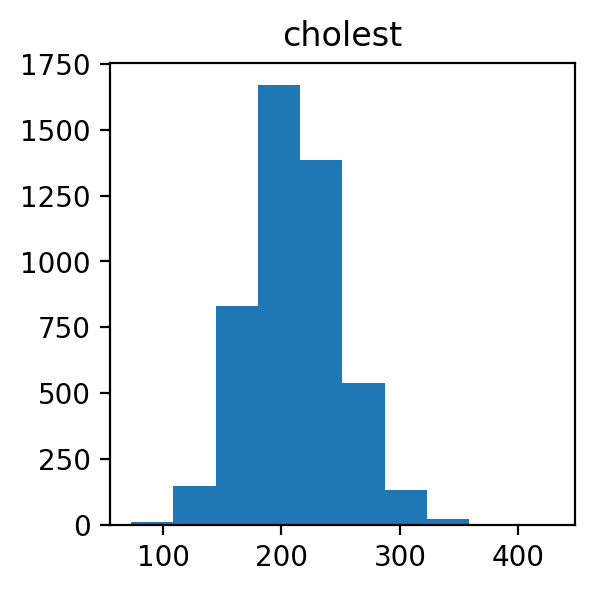

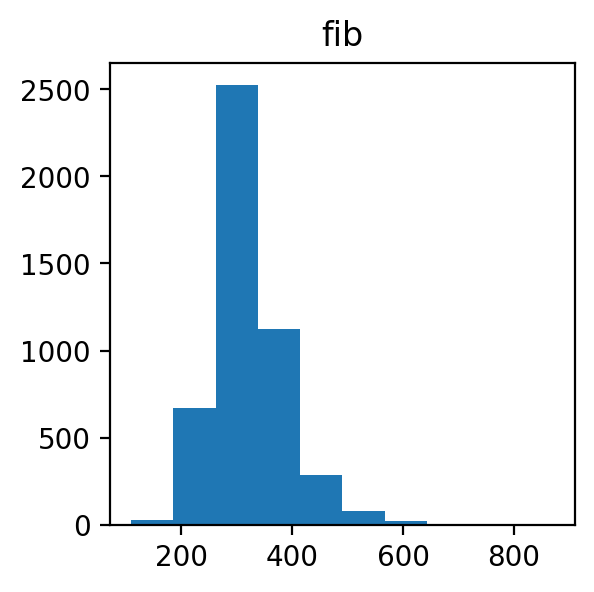

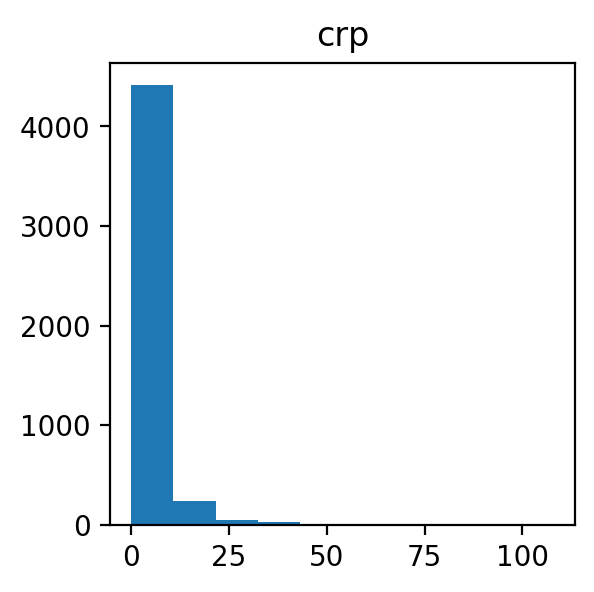

In [195]:
plt.figure(figsize=(3,3))
plt.hist(data['age'])
plt.title('age')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(data['bmi'])
plt.title('bmi')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(data['systBP'])
plt.title('systBP')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(data['aai'])
plt.title('aai')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(data['cholest'])
plt.title('cholest')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(data['fib'])
plt.title('fib')
plt.show()


plt.figure(figsize=(3,3))
plt.hist(data['crp'])
plt.title('crp')
plt.show()


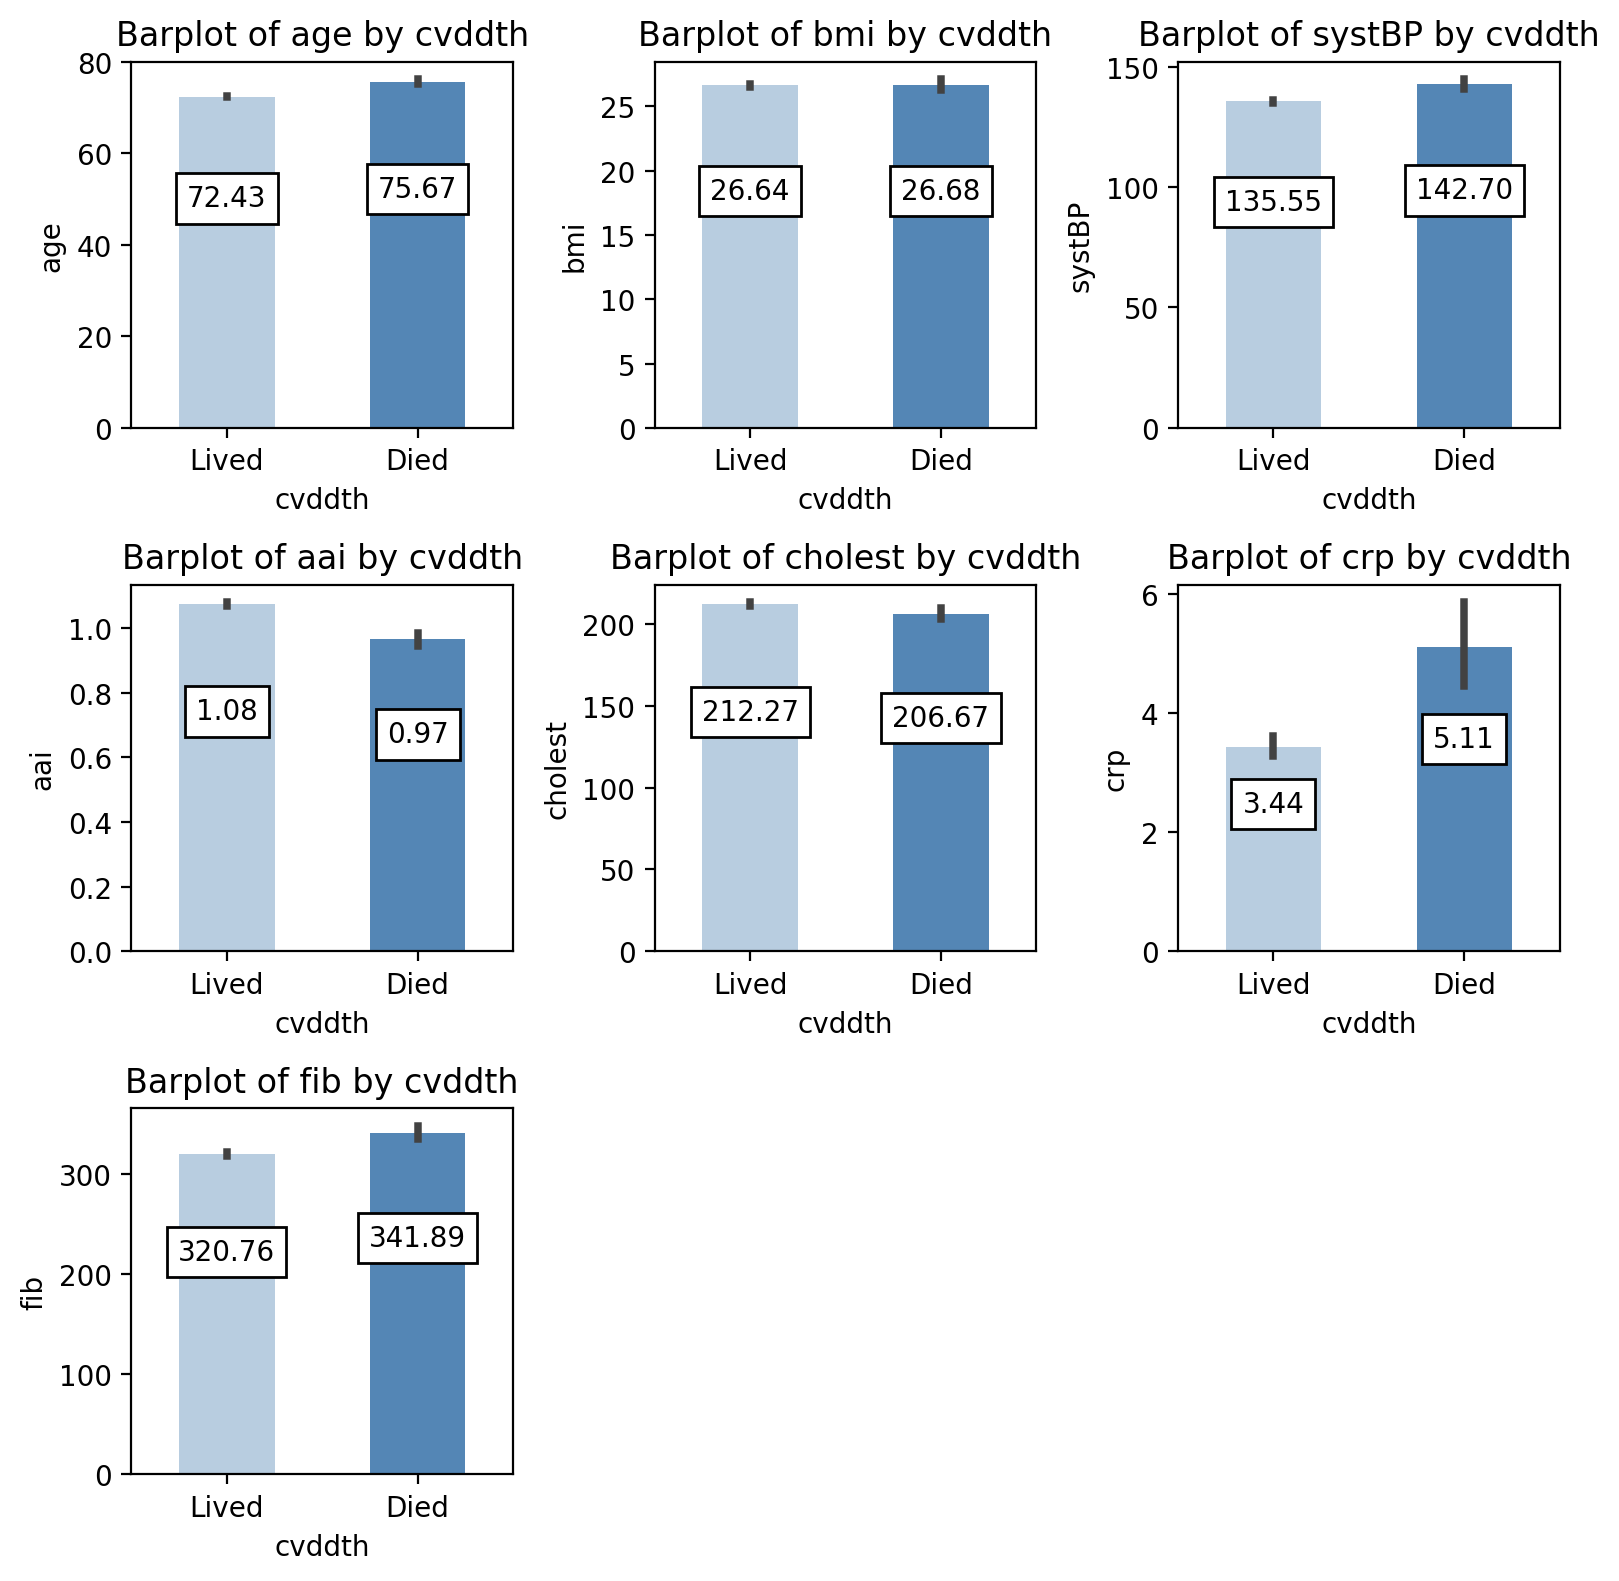

In [196]:
numerical_cols = numerical.columns

plt.figure(figsize=(8, 8))

for idx, col in enumerate(numerical_cols, 1):
    lived_mean = data[data['cvddth']==0][f'{col}'].mean()
    died_mean = data[data['cvddth']==1][f'{col}'].mean()

    plt.subplot(3, 3, idx)
    
    ax = sns.barplot(x=data['cvddth'], y=data[col], width=.5, palette=['#B1CDE7', '#4487C5'], estimator=np.mean) # '#8fd4ff', 
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height() - (.35* p.get_height()), '{:1.2f}'.format(p.get_height()), 
                fontsize=10, ha="center", va="bottom",
                bbox=dict(facecolor='white'))

    plt.xticks([0,1], labels=['Lived', 'Died'])
    plt.title(f'Barplot of {col} by cvddth')
    plt.ylabel(col)


plt.tight_layout()
plt.show()

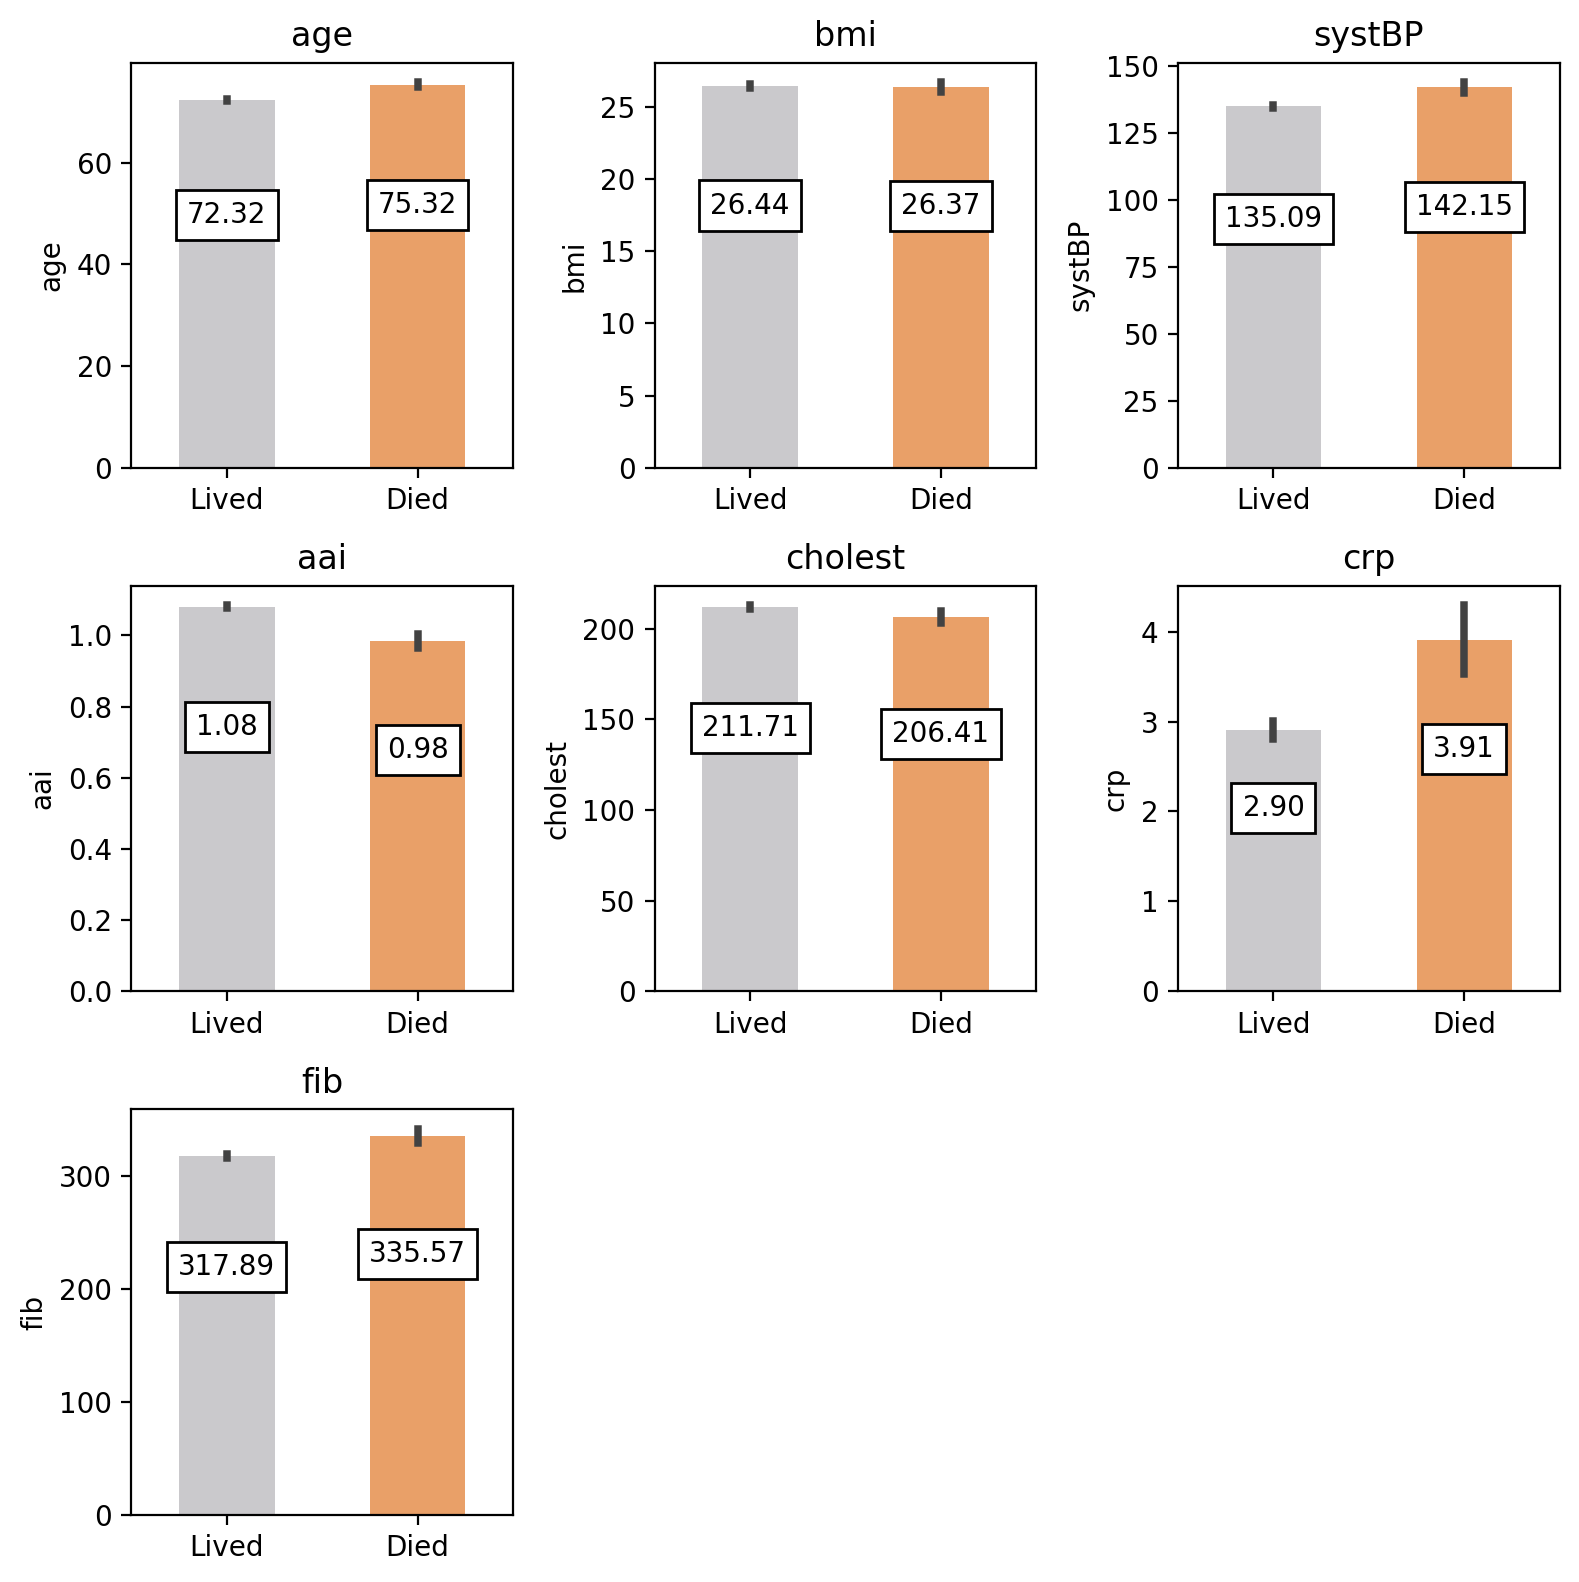

In [197]:
# Checking with removed outliers over 3sd away 

numerical_cols = numerical.columns

plt.figure(figsize=(8, 8))

for idx, col in enumerate(numerical_cols, 1):
    mean = data[col].mean()
    std_dev = data[col].std()
    
    cvddth_rm_outs = data[np.abs(data[col] - mean) <= 3*std_dev]['cvddth']
    var_rm_outs = data[np.abs(data[col] - mean) <= 3*std_dev][col]
    plt.subplot(3, 3, idx)
    
    ax = sns.barplot(x=cvddth_rm_outs, y=var_rm_outs, width=.5, palette=['#cac8cc', '#ff9d52'], estimator=np.mean) 
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height() - (.35* p.get_height()), '{:1.2f}'.format(p.get_height()), 
                fontsize=10, ha="center", va="bottom",
                bbox=dict(facecolor='white'))

    plt.xticks([0,1], labels=['Lived', 'Died'])
    plt.title(f'{col}')
    plt.ylabel(col)
    plt.xlabel('')

plt.tight_layout()
plt.show()

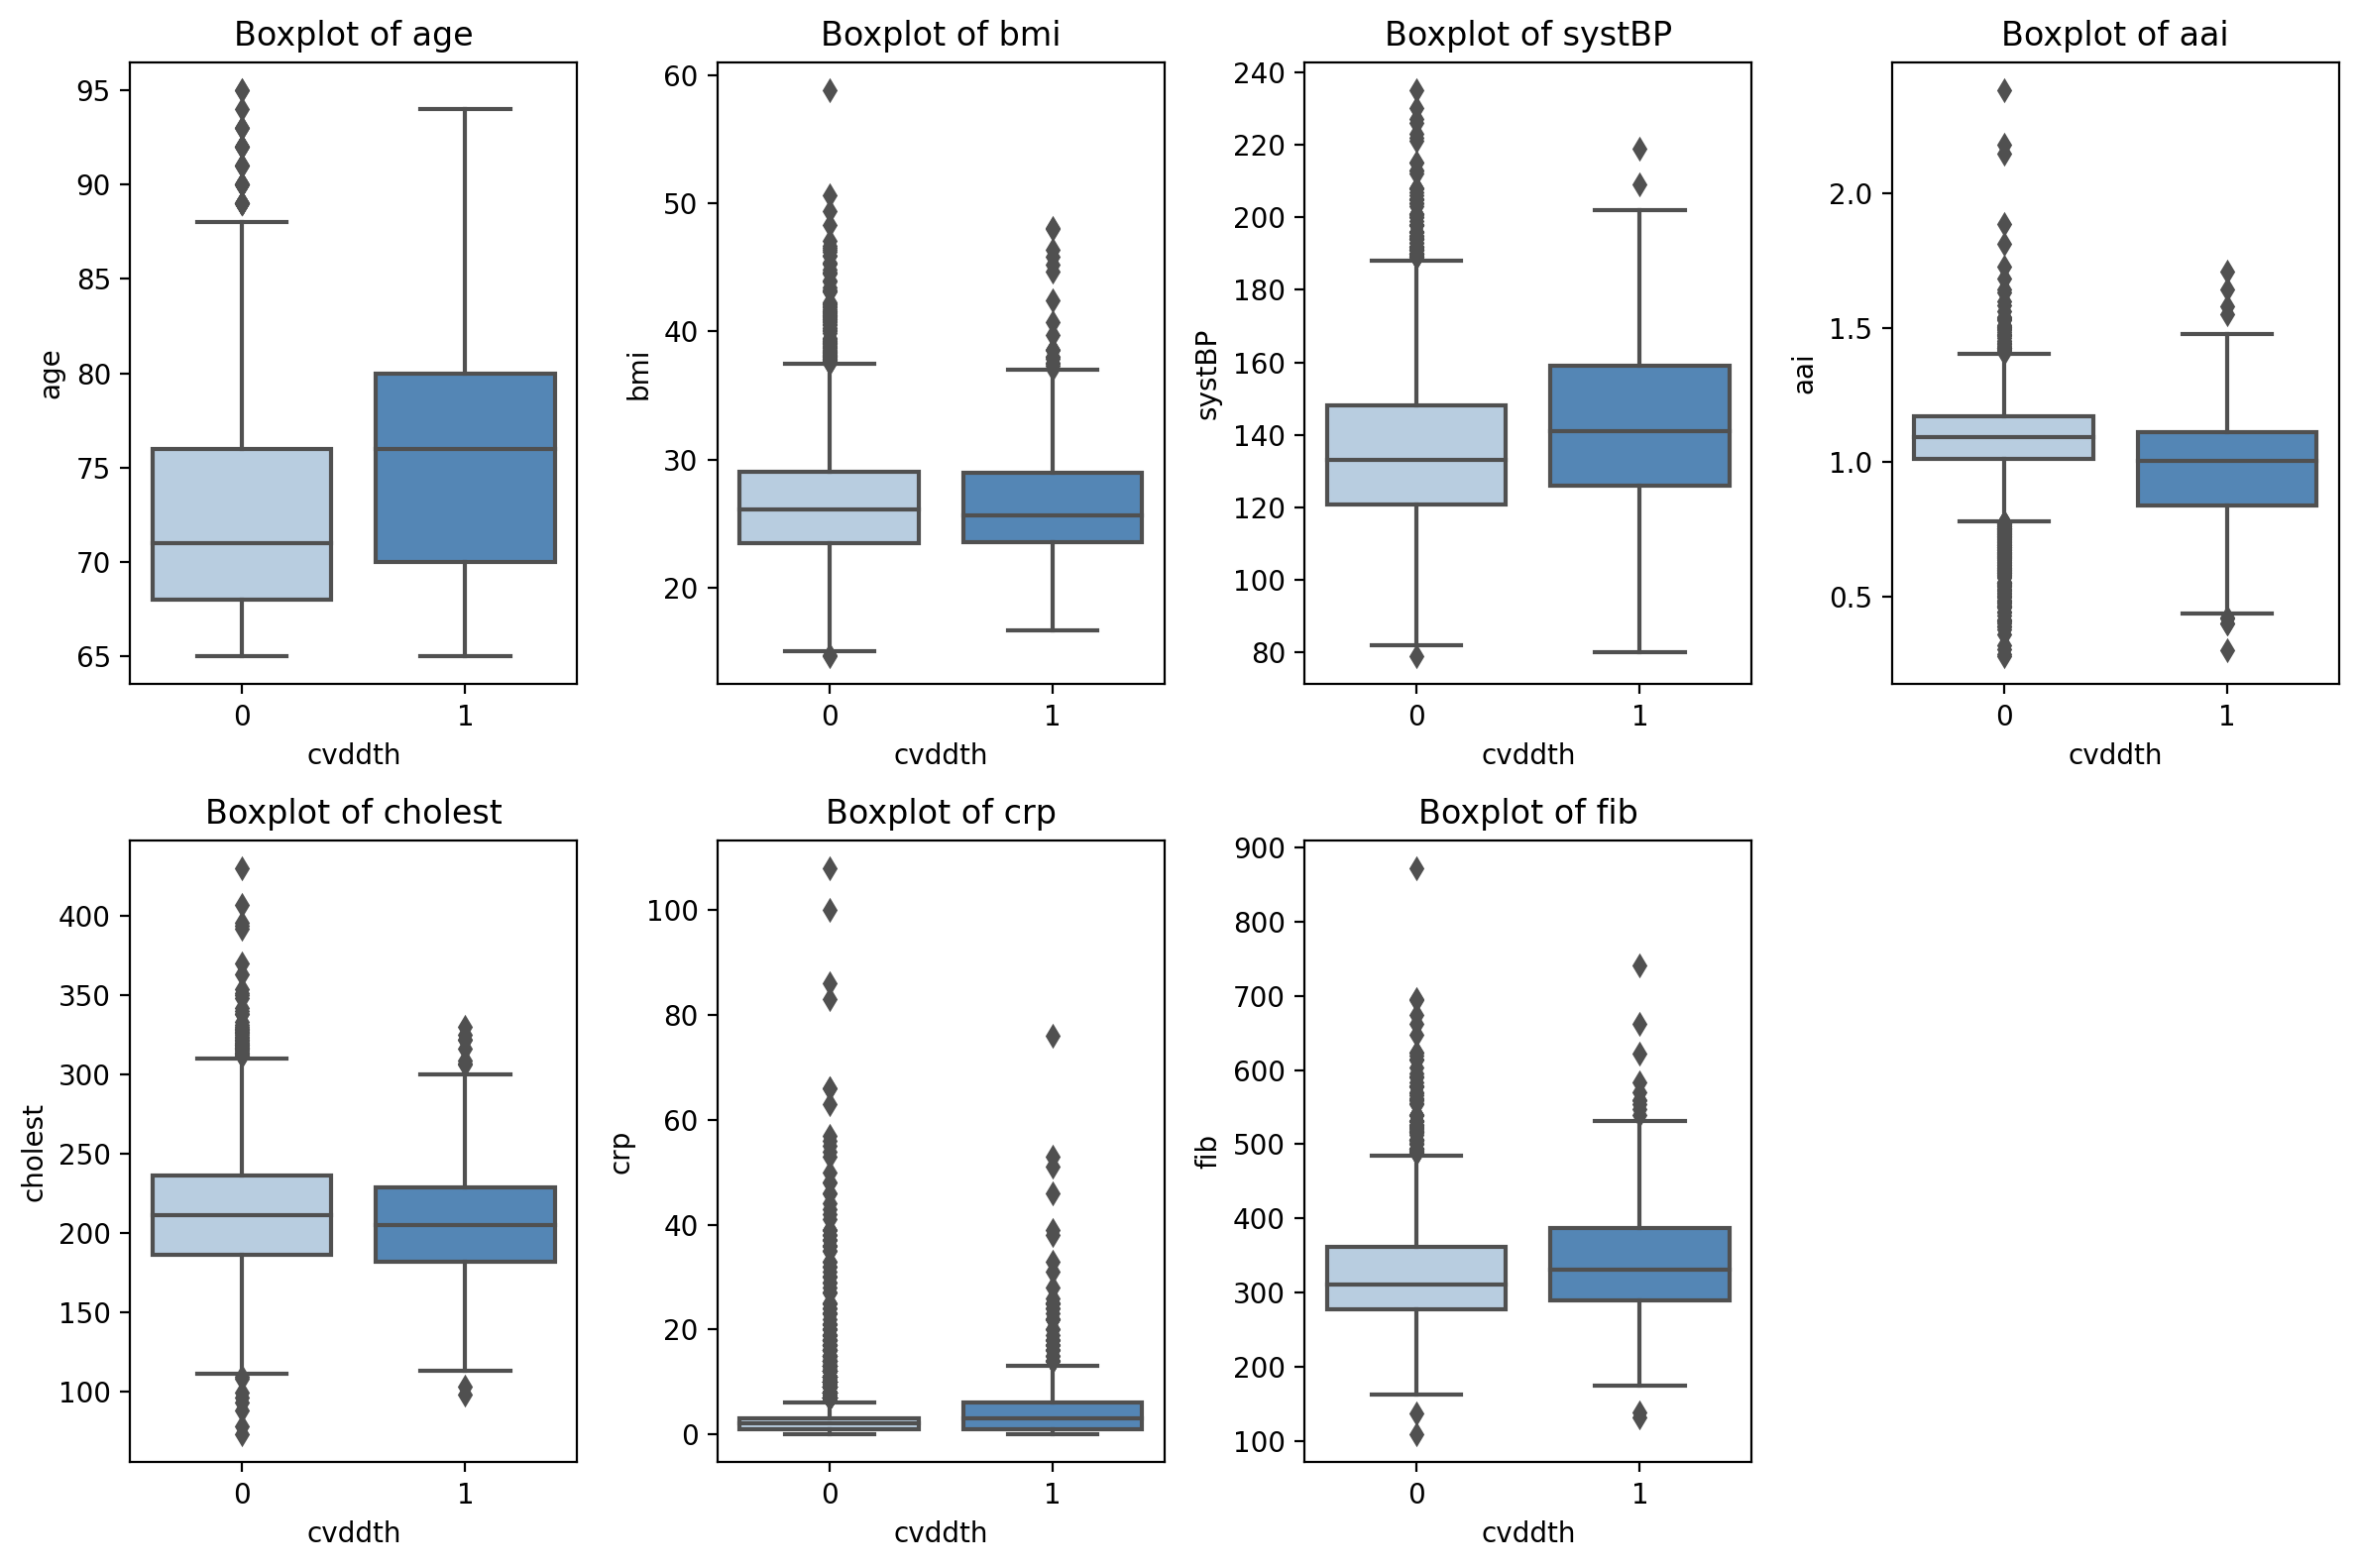

In [198]:
variables = ['age', 'bmi', 'systBP', 'aai', 'cholest', 'crp', 'fib']

# Setting up the figure and axis
plt.figure(figsize=(12, 8))

# Iterating over each variable for plotting
for idx, var in enumerate(variables, 1):
    plt.subplot(2, 4, idx)  # 2 rows and 4 columns of plots
    sns.boxplot(x='cvddth', y=var, data=data, palette=['#B1CDE7', '#4487C5'])
    plt.title(f'Boxplot of {var}')
    plt.xlabel('cvddth')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


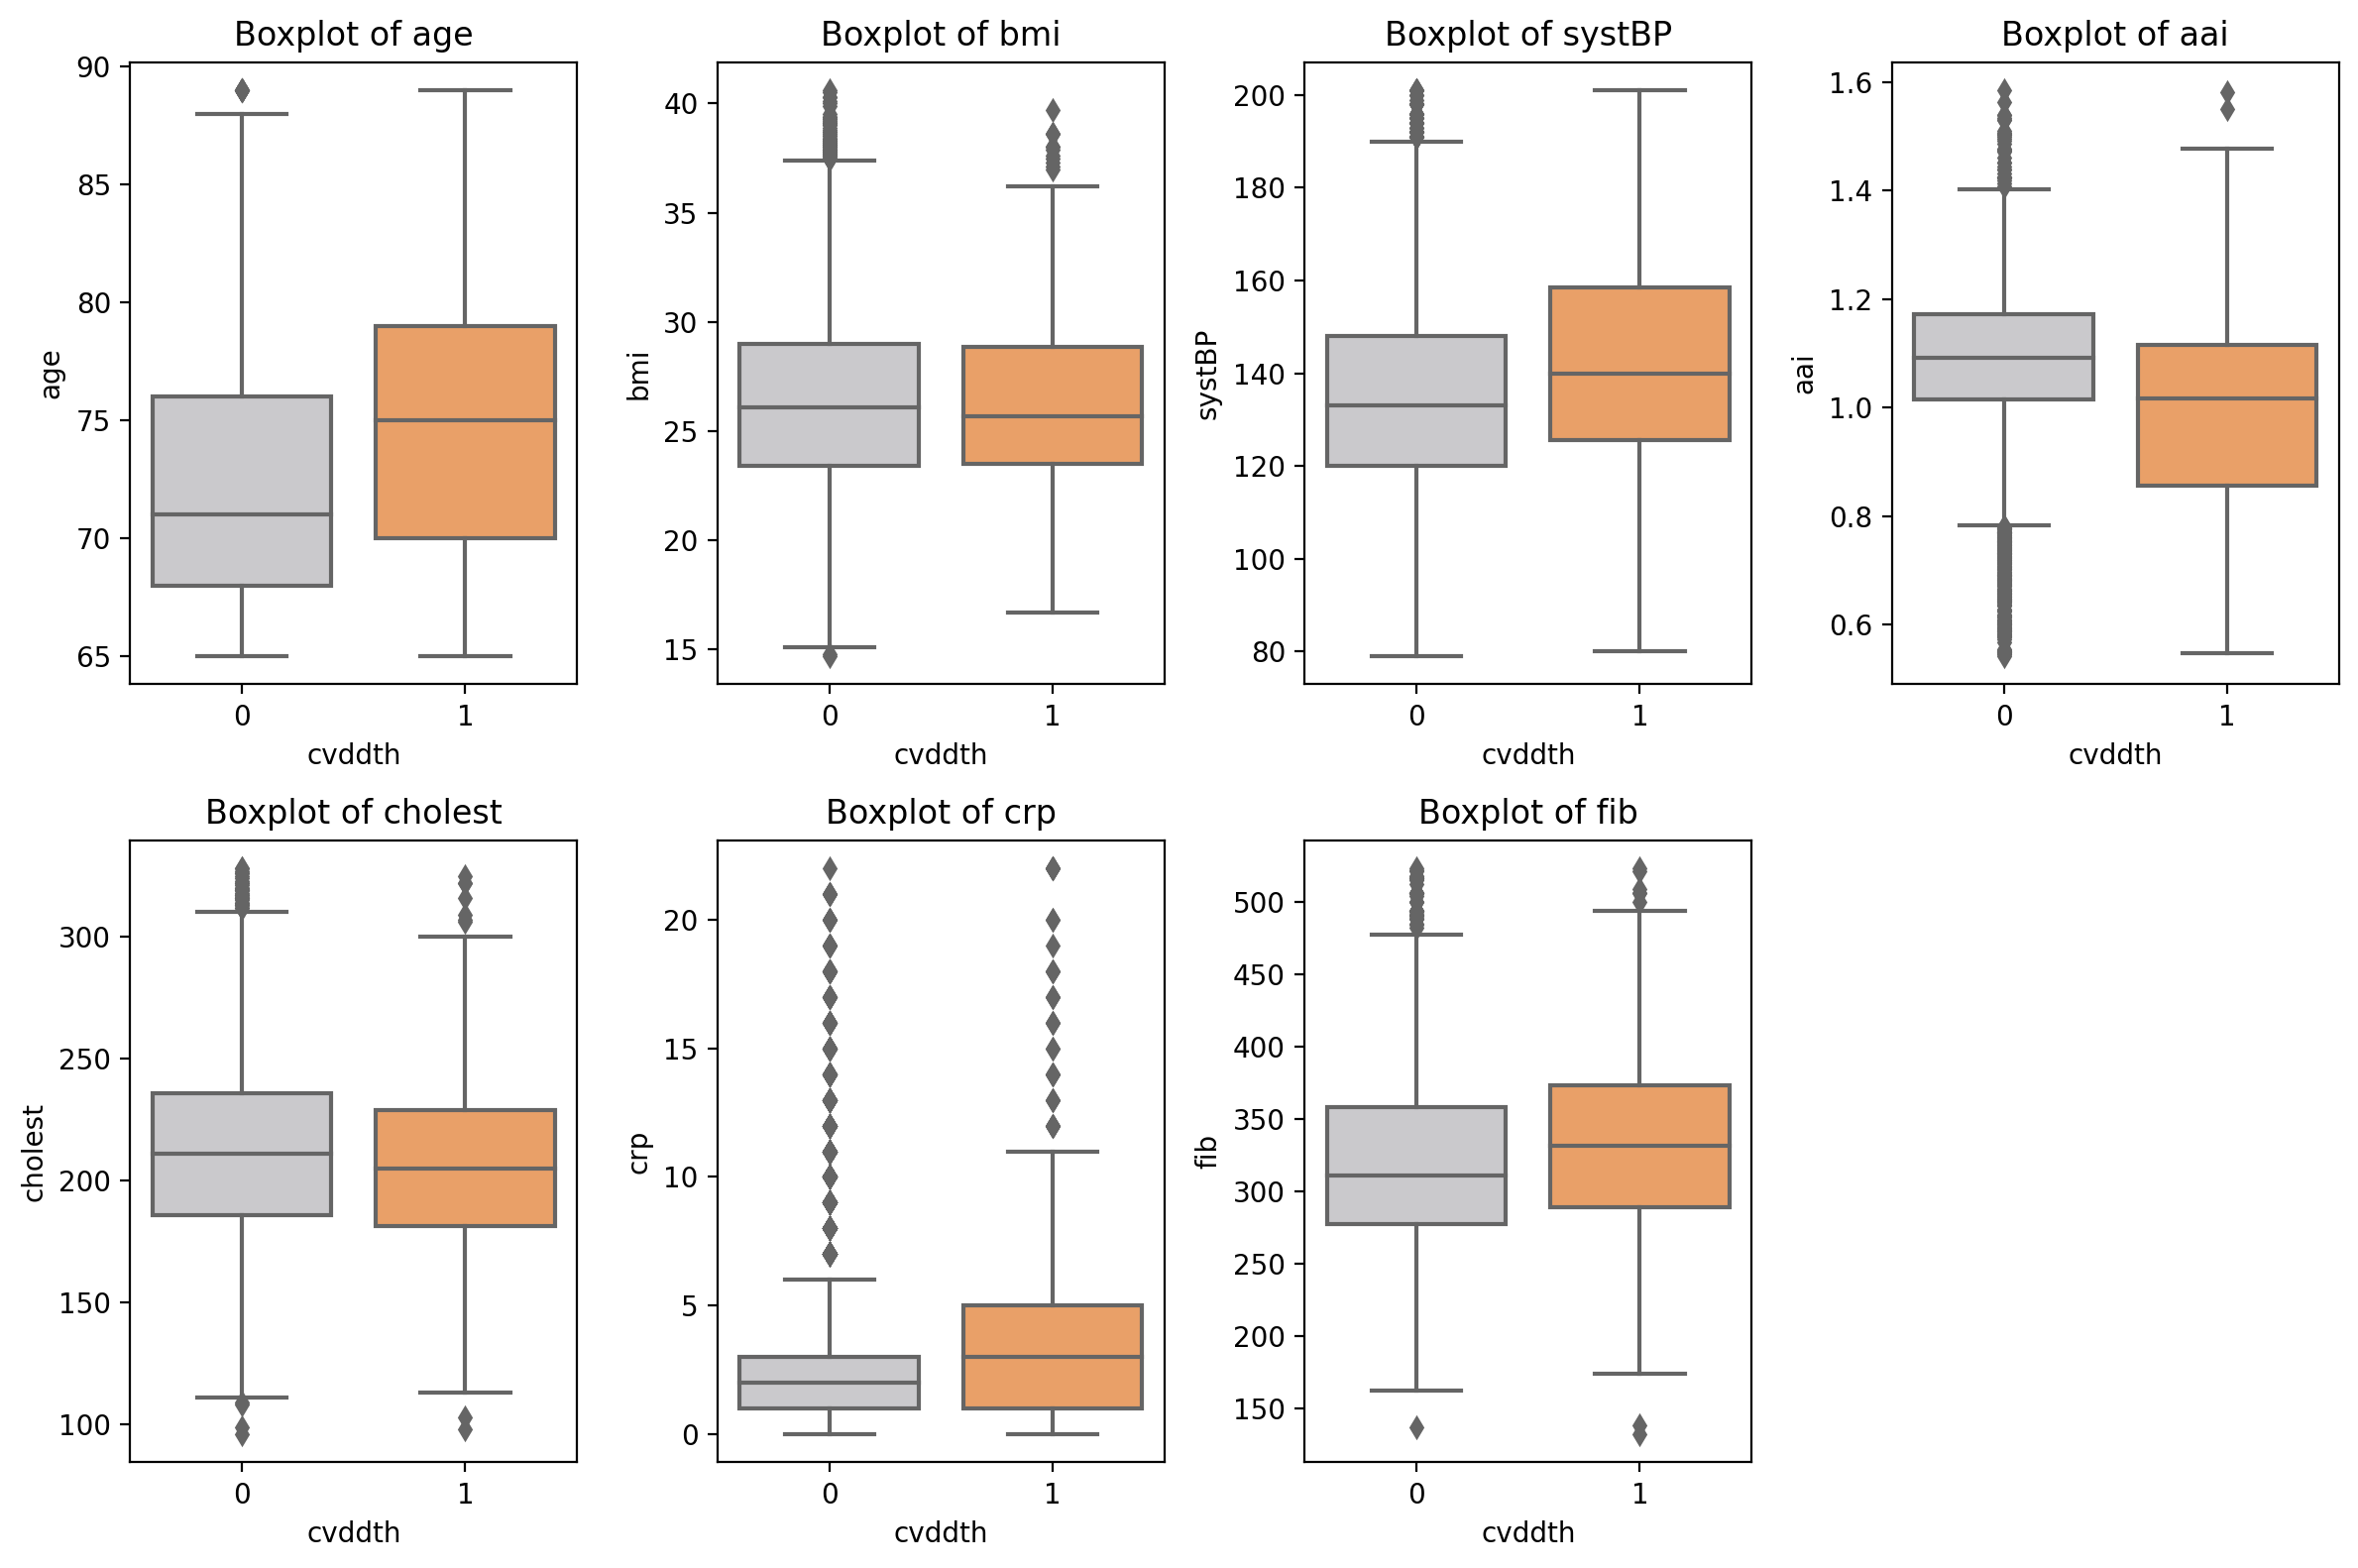

In [199]:
# Checking with removed outliers over 3sd away 

variables = ['age', 'bmi', 'systBP', 'aai', 'cholest', 'crp', 'fib']

plt.figure(figsize=(12, 8))


for idx, var in enumerate(variables, 1):    
    mean = data[var].mean()
    std_dev = data[var].std()
    
    cvddth_rm_outs = data[np.abs(data[var] - mean) <= 3*std_dev]['cvddth']
    var_rm_outs = data[np.abs(data[var] - mean) <= 3*std_dev][var]

    plt.subplot(2, 4, idx)  
    sns.boxplot(x=cvddth_rm_outs, y=var_rm_outs, palette=['#cac8cc', '#ff9d52'])

    plt.title(f'Boxplot of {var}', fontdict={'size':12})    
    
    

plt.tight_layout()
plt.show()

In [200]:
# Check correlation between numerical predictors
numerical.corr()

,age,bmi,systBP,aai,cholest,crp,fib
age,1.000000,-0.134196,0.194575,-0.198265,-0.079180,0.002197,0.071247
bmi,-0.134196,1.000000,0.069009,0.127317,0.030425,0.146336,0.139241
systBP,0.194575,0.069009,1.000000,-0.234487,0.034879,0.008305,0.045987
aai,-0.198265,0.127317,-0.234487,1.000000,-0.098065,-0.084746,-0.135425
cholest,-0.079180,0.030425,0.034879,-0.098065,1.000000,-0.077532,0.040982
crp,0.002197,0.146336,0.008305,-0.084746,-0.077532,1.000000,0.479590
fib,0.071247,0.139241,0.045987,-0.135425,0.040982,0.479590,1.000000


In [201]:
# t tests for cvddth (alive, dead) on numerical predictors

dead_group = data[data['cvddth'] == 1]
alive_group = data[data['cvddth'] == 0]

for col in ['age', 'bmi', 'systBP', 'aai','cholest','crp', 'fib']:    
    t_stat, p_val = stats.ttest_ind(dead_group[col], alive_group[col], equal_var=False) # Welch's t
    
    if p_val < 0.01: 
        print(f"{col}: significantly different (p-value = {p_val}) *** ")
    else:
        print(f"{col} not significantly different (p-value = {p_val})")

print(f'\nDead group: {len(dead_group)} participants.\nAlive group: {len(alive_group)} participants')

age: significantly different (p-value = 4.934177453898238e-25) *** 
bmi not significantly different (p-value = 0.833207854669788)
systBP: significantly different (p-value = 1.698899461934021e-10) *** 
aai: significantly different (p-value = 2.4726058731855622e-23) *** 
cholest: significantly different (p-value = 0.0024213866970410986) *** 
crp: significantly different (p-value = 5.686257366567234e-06) *** 
fib: significantly different (p-value = 9.53160386081029e-09) *** 

Dead group: 471 participants.
Alive group: 4272 participants


In [202]:
# Categorical Variables
categorical = data.drop(columns=['age', 'bmi', 'systBP', 'aai', 'cholest', 'crp', 'fib', 'ttodth'])

def get_contingency(var):
    tab = pd.crosstab(index=categorical[var], columns=categorical['cvddth'])
    print(f'{var} by cvddth:')
    return round(tab,3)

def get_proportions(var):
    print(f'{var} proportions:')
    tab = pd.crosstab(categorical[var], 'percent', colnames=[''])
    return round((tab/tab.sum())*100, 2)

In [203]:
print(get_contingency('smoker'))

smoker by cvddth:
cvddth     0    1
smoker           
0.0     3775  398
1.0      497   73


In [204]:
for var in categorical:
    print(get_proportions(var))

male proportions:
      percent
male         
0       57.69
1       42.31
bkrace proportions:
        percent
bkrace         
0         85.33
1         14.67
smoker proportions:
        percent
smoker         
0.0       87.98
1.0       12.02
estrogen proportions:
          percent
estrogen         
0.0         93.15
1.0          6.85
prevdis proportions:
         percent
prevdis         
0          77.17
1          22.83
diab2 proportions:
       percent
diab2         
0.0      84.27
1.0      15.73
death proportions:
       percent
death         
0        77.86
1        22.14
cvddth proportions:
        percent
cvddth         
0         90.07
1          9.93


In [205]:
cat_prop = {"Variable": ["male", "", "bkrace", "", "smoker", "", "estrogen", "", "prevdis", "", "diab2", "", "death", "", "cvddth", ""],
    "Category": [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    "Percentage (%)": [57.69, 42.31, 85.33, 14.67, 87.98, 12.02, 93.15, 6.85, 77.17, 22.83, 84.27, 15.73, 77.86, 22.14, 90.07, 9.93]}

df = pd.DataFrame(cat_prop)

from IPython.display import display, HTML
display(HTML(df.to_html(index=False)))

Variable,Category,Percentage (%)
male,0,57.69
,1,42.31
bkrace,0,85.33
,1,14.67
smoker,0,87.98
,1,12.02
estrogen,0,93.15
,1,6.85
prevdis,0,77.17
,1,22.83


In [206]:
# Chi-squared test
results=[]
for predictor in categorical:
    if predictor == 'cvddth' or predictor == 'death':
        continue
    else:
        contingency = pd.crosstab(data[predictor], data['cvddth'])
        chi2, p, _, _ = chi2_contingency(contingency)
        results.append((predictor, chi2, p))

for predictor, chi2, p in results:
    print(f"{predictor}:")
    print(f"Chi2 value: {chi2:.4f}")
    print(f"P-value: {p:.4f}\n")

male:
Chi2 value: 50.3355
P-value: 0.0000

bkrace:
Chi2 value: 4.5908
P-value: 0.0321

smoker:
Chi2 value: 5.6337
P-value: 0.0176

estrogen:
Chi2 value: 13.0169
P-value: 0.0003

prevdis:
Chi2 value: 250.9250
P-value: 0.0000

diab2:
Chi2 value: 54.6201
P-value: 0.0000



Checking VIF/GVIF 

In [207]:
# VIF
y, X = dmatrices('cvddth ~ age + male + bkrace + smoker + estrogen + prevdis + diab2 + bmi + systBP + aai + cholest + crp + fib', 
                 data=data, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor   features
0   421.399174  Intercept
1     1.152025        age
2     1.184430       male
3     1.060504     bkrace
4     1.071634     smoker
5     1.099224   estrogen
6     1.070847    prevdis
7     1.075588      diab2
8     1.171816        bmi
9     1.118443     systBP
10    1.207831        aai
11    1.134161    cholest
12    1.352866        crp
13    1.382874        fib


In [208]:
# GVIF

def calculate_GVIF(all_vars, var):
    """
    Calculate GVIF between one categorical variarble (var) and other variables (all_vars)
    """
    A = pd.get_dummies(all_vars[var], drop_first = True).corr().to_numpy() #get corr matrix of categorical variable
    columns = list(all_vars.columns) # seperate categorical var from other vars in list
    columns.remove(var)
    B = pd.get_dummies(all_vars[columns], drop_first = True).corr().to_numpy() #get corr matrix of other variables
    C = pd.get_dummies(all_vars, drop_first = True).corr().to_numpy() #get corr matrix of all variables
    GVIF = (np.linalg.det(A)*np.linalg.det(B)) / np.linalg.det(C)
    return GVIF

categorical = data.drop(columns=['age', 'bmi', 'systBP', 'aai', 'cholest', 'crp', 'fib', 'ttodth'])

print('GVIF^(1/2*df) \t features')
for var in categorical.columns:
    gvif = calculate_GVIF(data, var)
    df = len(np.unique(data[f'{var}'])) - 1
    adj_gvif = gvif**(1/(2*df))
    print(f'{round(adj_gvif,6)} \t {var}')

GVIF^(1/2*df) 	 features
1.096827 	 male
1.254205 	 bkrace
1.040413 	 smoker
1.048706 	 estrogen
1.052697 	 prevdis
1.043211 	 diab2
1.699476 	 death
1.298016 	 cvddth


## Fitting the Logistic Regression Model

Full model:  $cvddth \sim age + male + bkrace + smoker + estrogen + prevdis + diab2 + bmi + systBP + aai + cholest + crp + fib$

In [209]:
def get_metrics_from_log_reg(data, formula): 
    y, X = dmatrices(formula, data=data, return_type='dataframe')
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=105)

    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(x_train, y_train.values.ravel()) # Use ravel() to convert y_train into a 1D array

    # Get accuracy
    print(f"Accuracy: {round(logreg.score(x_test, y_test)*100, 2)}%")

    # Calculate precision
    y_pred = logreg.predict(x_test)
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {round(precision*100, 2)}%")

    # Get F1 score 
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.2f}")

    # Get ROC-AUC
    auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC: {auc:.2f}")

In [220]:
print('Full model.')
form = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(estrogen) + C(prevdis) + C(diab2) + bmi + systBP + aai + cholest + crp + fib'
model = smf.glm(formula = form, data=data, family=sm.families.Binomial()).fit()
print(model.summary())

get_metrics_from_log_reg(data, form)

Full model.
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cvddth   No. Observations:                 4743
Model:                            GLM   Df Residuals:                     4729
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1284.1
Date:                Thu, 12 Oct 2023   Deviance:                       2568.2
Time:                        16:51:37   Pearson chi2:                 4.31e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1002
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -9

Reduced model:  $cvddth \sim age + male + bkrace + smoker + prevdis + diab2 + systBP + aai + crp + fib$

In [233]:
data['log_crp'] = np.log(data['crp'] + 1)

print('Reduced model with log(crp).')
form_2 = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2)  +systBP + aai  + log_crp + fib'
model_2 = smf.glm(formula = form_2, data=data, family=sm.families.Binomial()).fit()
print(model_2.summary())

get_metrics_from_log_reg(data, form_2)

Reduced model with log(crp).
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cvddth   No. Observations:                 4743
Model:                            GLM   Df Residuals:                     4732
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1282.0
Date:                Thu, 12 Oct 2023   Deviance:                       2564.0
Time:                        17:21:31   Pearson chi2:                 4.36e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1010
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept  

In [215]:
# Influential points: Pearson Residuals
pearson_residuals = model.resid_pearson.copy()
standardized_pearson_residuals = (pearson_residuals - pearson_residuals.mean()) / pearson_residuals.std()
pearson_outliers = standardized_pearson_residuals[np.abs(standardized_pearson_residuals) >= 3] 
sorted_pearson_residuals = pearson_outliers.abs().sort_values(ascending=False)
top_20_pearson_outliers = sorted_pearson_residuals.head(20) 
pearson_outliers_ind = top_20_pearson_outliers.index.tolist()

# Remove outliers from data
data_cleaned_pearson = data.drop(pearson_outliers_ind)

In [234]:
print('Reduced model with influential points removed.')
data_cleaned_pearson['log_crp'] = np.log(data_cleaned_pearson['crp']+1)

form_3 = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2) + systBP + aai + log_crp + fib'

model_3 = smf.glm(formula = form_3, data=data_cleaned_pearson, family=sm.families.Binomial()).fit()
print(model_3.summary())

get_metrics_from_log_reg(data_cleaned_pearson, form_3)

Reduced model with influential points removed.
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cvddth   No. Observations:                 4723
Model:                            GLM   Df Residuals:                     4712
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1204.8
Date:                Thu, 12 Oct 2023   Deviance:                       2409.5
Time:                        17:23:16   Pearson chi2:                 3.83e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1130
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [229]:
print(f'Model 1: AIC: {model.aic}, BIC: {model.bic_llf}')
print(f'Model 2: AIC: {model_2.aic}, BIC: {model_2.bic_llf}')
print(f'Model 3: AIC: {model_3.aic}, BIC: {model_3.bic_llf}')

Model 1: AIC: 2596.2376644567066, BIC: 2686.739616218993
Model 2: AIC: 2585.9670354678274, BIC: 2657.0757118524807
Model 3: AIC: 2431.5119286770205, BIC: 2502.574122845878


### Weighted Logistic Regression

In [66]:
weights = np.where(data['cvddth'] == 1, len(data[data['cvddth'] == 0])/len(data[data['cvddth'] == 1]),  1)


print('Weighted reduced model (no bmi, estrogen, or cholest).')
form = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2)  + systBP + aai  + crp + fib'

model = smf.glm(formula = form, data=data, family=sm.families.Binomial(), freq_weights=weights).fit()
print(model.summary())

get_metrics_from_log_reg(data, form)

Weighted reduced model (no bmi, estrogen, or cholest).
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cvddth   No. Observations:                 4762
Model:                            GLM   Df Residuals:                  8571.61
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4712.4
Date:                Thu, 12 Oct 2023   Deviance:                       9424.8
Time:                        14:14:54   Pearson chi2:                 8.99e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4051
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [67]:
print('Weighted reduced model with log-transformed crp.')
data['log_crp'] = np.log(data['crp'] + 1)

form_2_logcrp = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2)  + systBP + aai  + log_crp + fib'
model_2 = smf.glm(formula = form_2_logcrp, data=data, family=sm.families.Binomial(), freq_weights=weights).fit()
print(model_2.summary())
get_metrics_from_log_reg(data, form_2_logcrp)

Weighted reduced model with log-transformed crp.
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cvddth   No. Observations:                 4762
Model:                            GLM   Df Residuals:                  8571.61
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4697.9
Date:                Thu, 12 Oct 2023   Deviance:                       9395.8
Time:                        14:14:55   Pearson chi2:                 8.94e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4087
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [68]:
# Influential points: Pearson Residuals
pearson_residuals = model_2.resid_pearson.copy()
standardized_pearson_residuals = (pearson_residuals - pearson_residuals.mean()) / pearson_residuals.std()
pearson_outliers = standardized_pearson_residuals[np.abs(standardized_pearson_residuals) >= 3] 
sorted_pearson_residuals = pearson_outliers.abs().sort_values(ascending=False)
top_20_pearson_outliers = sorted_pearson_residuals.head(20)  # Replace N with your desired number
pearson_outliers_ind = top_20_pearson_outliers.index.tolist()

# Remove outliers from data
data_cleaned_pearson = data.drop(pearson_outliers_ind)

In [88]:
weights_rm_outliers

array([1.        , 9.08097166, 1.        , ..., 1.        , 1.        ,
       1.        ])

In [84]:
weights_rm_outliers = np.where(data_cleaned_pearson['cvddth'] == 1, 
                               len(data_cleaned_pearson[data_cleaned_pearson['cvddth'] == 0])
                               /len(data_cleaned_pearson[data_cleaned_pearson['cvddth'] == 1]),
                                1)

print('Weighted reduced model with log_crp and removed influential points.')

form_3 = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2)  + systBP + aai + log_crp + fib'
model_3 = smf.glm(formula = form_3, data=data_cleaned_pearson, family=sm.families.Binomial(), freq_weights=weights_rm_outliers).fit()

print(model_3.summary())
get_metrics_from_log_reg(data_cleaned_pearson, form_3)

Weighted reduced model with log_crp and removed influential points.
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cvddth   No. Observations:                 4742
Model:                            GLM   Df Residuals:                  8537.14
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4584.9
Date:                Thu, 12 Oct 2023   Deviance:                       9169.9
Time:                        14:29:19   Pearson chi2:                 8.57e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4318
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [70]:
print(f'Model 1: AIC: {model.aic}, BIC: {model.bic_llf}')
print(f'Model 2: BIC: {model_2.aic}, BIC: {model_2.bic_llf}')
print(f'Model 3: BIC: {model_3.aic}, BIC: {model_3.bic_llf}')

Model 1: AIC: 9446.847880064393, BIC: 9524.480308967102
Model 2: BIC: 9417.816851100226, BIC: 9495.449280002935
Model 3: BIC: 9191.893130196668, BIC: 9269.481286113418


## Resampling

#### Undersample

In [225]:
data['log_crp'] = np.log(data['crp'] + 1)

dead_group = data[data['cvddth'] == 1]
alive_group = data[data['cvddth'] == 0]

print(len(alive_group)) #4272
print(len(dead_group)) #471

new_alive = alive_group.sample(471) # random sample of 471 participants who lived
resampled = pd.concat([new_alive, dead_group], axis=0).reset_index(drop=True) 

In [221]:
print("Full model with undersampling.")

form = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(estrogen) + C(prevdis) + C(diab2) + bmi + systBP + aai + cholest + log_crp'
model = smf.glm(formula = form, data=resampled, family=sm.families.Binomial()).fit()
print(model.summary())


orig_y, orig_X = dmatrices(form, data=data, return_type='dataframe')
orig_x_train, orig_x_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, random_state=105)

y, X = dmatrices(form, data=resampled, return_type='dataframe')
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=105)

logreg = LogisticRegression(max_iter=10000)
logreg.fit(x_train, y_train.values.ravel()) # Use ravel() to convert y_train into a 1D array

# Get accuracy
print(f"Accuracy: {round(logreg.score(orig_x_test, orig_y_test)*100, 2)}%")

# Calculate precision
y_pred = logreg.predict(orig_x_test)
precision = precision_score(orig_y_test, y_pred)
print(f"Precision: {round(precision*100, 2)}%")

f1 = f1_score(orig_y_test, y_pred)
print(f"F1-Score: {f1:.2f}")

auc = roc_auc_score(orig_y_test, y_pred)
print(f"ROC-AUC: {auc:.2f}")

In [222]:
print("Reduced model with estrogen, bmi, and cholest removed with undersampling.")
form_2 = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2) + systBP + aai + log_crp'
model_2 = smf.glm(formula = form_2, data=resampled, family=sm.families.Binomial()).fit()
print(model_2.summary())

orig_y, orig_X = dmatrices(form_2, data=data, return_type='dataframe')
orig_x_train, orig_x_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, random_state=105)

y, X = dmatrices(form_2, data=resampled, return_type='dataframe')
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=105)

logreg = LogisticRegression(max_iter=10000)
logreg.fit(x_train, y_train.values.ravel()) # Use ravel() to convert y_train into a 1D array

# Get accuracy
print(f"Accuracy: {round(logreg.score(orig_x_test, orig_y_test)*100, 2)}%")

# Calculate precision
y_pred = logreg.predict(orig_x_test)
precision = precision_score(orig_y_test, y_pred)
print(f"Precision: {round(precision*100, 2)}%")

f1 = f1_score(orig_y_test, y_pred)
print(f"F1-Score: {f1:.2f}")

auc = roc_auc_score(orig_y_test, y_pred)
print(f"ROC-AUC: {auc:.2f}")

In [89]:
# Influential points

# Pearson Residuals
pearson_residuals = model_2.resid_pearson.copy()
standardized_pearson_residuals = (pearson_residuals - pearson_residuals.mean()) / pearson_residuals.std()
pearson_outliers = standardized_pearson_residuals[np.abs(standardized_pearson_residuals) >= 3] 
sorted_pearson_residuals = pearson_outliers.abs().sort_values(ascending=False)
top_20_pearson_outliers = sorted_pearson_residuals.head(20)  
pearson_outliers_ind = top_20_pearson_outliers.index.tolist()

# Remove outliers from data
resampled_cleaned_pearson = resampled.drop(pearson_outliers_ind)

In [224]:
print("Reduced model with influential points (from Pearson residuals) removed with undersampling.")
form_3 = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2) + systBP + aai + log_crp'
model_3 = smf.glm(formula = form_3, data=resampled_cleaned_pearson, family=sm.families.Binomial()).fit()
print(model_3.summary())


orig_y, orig_X = dmatrices(form_3, data=data, return_type='dataframe')
orig_x_train, orig_x_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, random_state=105)

y, X = dmatrices(form_3, data=resampled_cleaned_pearson, return_type='dataframe')
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=105)

logreg = LogisticRegression(max_iter=10000)
logreg.fit(x_train, y_train.values.ravel()) # Use ravel() to convert y_train into a 1D array

# Get accuracy
print(f"Accuracy: {round(logreg.score(orig_x_test, orig_y_test)*100, 2)}%")

# Calculate precision
y_pred = logreg.predict(orig_x_test)
precision = precision_score(orig_y_test, y_pred)
print(f"Precision: {round(precision*100, 2)}%")

f1 = f1_score(orig_y_test, y_pred)
print(f"F1-Score: {f1:.2f}")

auc = roc_auc_score(orig_y_test, y_pred)
print(f"ROC-AUC: {auc:.2f}")

In [223]:
print(f'Model 1: AIC: {model.aic}, BIC: {model.bic_llf}')
print(f'Model 2: BIC: {model_2.aic}, BIC: {model_2.bic_llf}')
print(f'Model 3: BIC: {model_3.aic}, BIC: {model_3.bic_llf}')

#### Stratified Bootstrapping

In [252]:
form_2 = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2) + systBP + aai + log_crp + fib'
y, X = dmatrices(form_2, data=data, return_type='dataframe')
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=105)

for_boot_dead = data[data['cvddth']==0]
for_boot_alive = data[data['cvddth']==1]

n_iterations = 1000

bootstrap_results = []

for i in range(n_iterations):

    bootstrapped_dead = resample(for_boot_dead, replace=True, n_samples=len(for_boot_dead))
    bootstrapped_alive = resample(for_boot_alive, replace=True, n_samples=len(for_boot_dead))
    bootstrapped_sample = pd.concat([bootstrapped_dead, bootstrapped_alive], axis=0).reset_index(drop=True)

    y_boot, X_boot = dmatrices(form_2, data=bootstrapped_sample, return_type='dataframe')

    # Train your model on the bootstrapped sample
    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(X_boot, y_boot.values.ravel()) 
    
    # Evaluate your model
    accuracy = logreg.score(x_test, y_test)
    y_pred = logreg.predict(x_test)
    precision = precision_score(y_test, y_pred)

    # Store the performance metrics
    bootstrap_results.append((accuracy, precision))

# Convert results to a DataFrame for easy summary statistics
bootstrap_df = pd.DataFrame(bootstrap_results, columns=['Accuracy', 'Precision'])

# Calculate mean and confidence intervals (e.g., 2.5th percentile and 97.5th percentile)
mean_accuracy = bootstrap_df['Accuracy'].mean()
mean_precision = bootstrap_df['Precision'].mean()
ci_accuracy = (bootstrap_df['Accuracy'].quantile(0.025), bootstrap_df['Accuracy'].quantile(0.975))
ci_precision = (bootstrap_df['Precision'].quantile(0.025), bootstrap_df['Precision'].quantile(0.975))

print(f"Mean Accuracy: {round(mean_accuracy*100, 2)}%")
print(f"Mean Precision: {round(mean_precision*100, 2)}%")
print(f"Accuracy 95% CI: ({round(ci_accuracy[0]*100, 2)}%, {round(ci_accuracy[1]*100, 2)}%)")
print(f"Precision 95% CI: ({round(ci_precision[0]*100, 2)}%, {round(ci_precision[1]*100, 2)}%)")

# Mean Accuracy: 74.62%
# Mean Precision: 25.38%
# Accuracy 95% CI: (73.02%, 76.14%)
# Precision 95% CI: (24.15%, 26.63%)

Mean Accuracy: 75.16%
Mean Precision: 25.75%
Accuracy 95% CI: (74.62%, 75.72%)
Precision 95% CI: (25.21%, 26.35%)


## Alternative Model Approaches

#### Random Forest

In [227]:
print('Random Forest of full model and full dataset.')

form = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(estrogen) + C(prevdis) + C(diab2) + bmi + systBP + aai + cholest + crp'
y, X = dmatrices(form, data=data, return_type='dataframe')
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=105)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train.values.ravel())

y_pred_rf = rf_classifier.predict(x_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {round(accuracy_rf*100, 2)}%")

precision_rf = precision_score(y_test, y_pred_rf)
print(f"Random Forest Precision: {round(precision_rf*100, 2)}%")

#### XGBoost

In [112]:
import xgboost as xgb

In [228]:
print('Reduced Model XGBoost')
formula = 'cvddth ~ age + C(male) + C(bkrace) + C(smoker) + C(prevdis) + C(diab2) + systBP + aai + crp'

y, X = dmatrices(formula, data=data, return_type='dataframe')
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=105)

invalid_columns = [col for col in x_train.columns if any(char in col for char in ['[', ']', '<'])]

for col in invalid_columns:
    new_name = col.replace('[', '_').replace(']', '_').replace('<', '_')
    x_train.rename(columns={col: new_name}, inplace=True)
    x_test.rename(columns={col: new_name}, inplace=True)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Set parameters (these are basic and can be tuned)
param = {
    'max_depth': 3,  # Maximum depth of a tree
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',  # Logarithmic loss metric
    'seed': 42  # Random seed for reproducibility
}

# Train the model
num_round = 100  # Number of boosting rounds
bst = xgb.train(param, dtrain, num_round)

# Make predictions
y_pred_prob = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]  # Convert probabilities to class labels

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")